In [25]:
import dgl
import numpy as np

# 1.建图

In [26]:
def build_karate_club_graph():
    # 上下各有78个元素，每个位置的元素分别对应边起点和终点
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10, 10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21, 25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4, 5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,  24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23, 29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,         31, 32])
    # DGL中的边为单向边，即创建无向图需两次
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.graph((u, v))

In [27]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


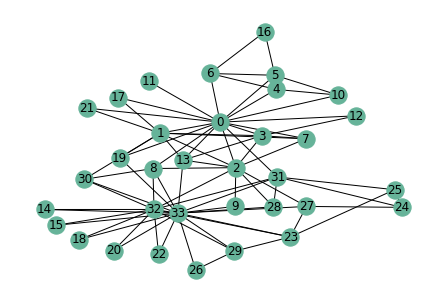

In [28]:
import networkx as nx
# networkx支持无向图，因此转化的时候要注意指定无向图
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
# 设置显示label和颜色
nx.draw(nx_G, pos, with_labels=True, node_color=[[.4, .7, .6]])

# 2.设置特征

随意弄个5维的向量随机初始化

In [29]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

# 一次初始化34个结点
embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
# 然后丢进图的ndata字典
G.ndata['feat'] = embed.weight

In [30]:
# 打印特征

# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])


tensor([-0.8358, -0.1020,  0.7134, -0.8487, -0.2828], grad_fn=<SelectBackward>)
tensor([[-0.3299,  2.2454,  0.7900,  0.6229, -0.8008],
        [-2.1978, -1.1765,  0.1254,  1.0418, -1.0453]],
       grad_fn=<IndexBackward>)


# 3.模型


In [31]:
# GCN在做消息传递的时候要拼接节点本身的信息。

# 再复习一下定义模型套路：
# 1.自定义卷积层或者使用DGL自带的卷积层对模型进行初始化（init，注意维度）；
# 2.定义模型结构（forward，注意层数）；

from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self,in_feats,hidden_size,num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self,g,inputs):
        h = self.conv1(g,inputs)
        h = torch.relu(h)
        h = self.conv2(g,h)
        return h
    
net = GCN(5,5,2)

# 4.数据初始化

In [32]:
inputs = embed.weight
labeled_nodes = torch.tensor([0,33])
labels = torch.tensor([0,1])

# 5. train

### 训练套路：

1.创建优化器，通常是Adam

2.丢训练数据

3.计算Loss

4.反向传播更新模型参数

In [33]:
import itertools

# 1.创建优化器
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr = 0.01)
all_logits = [] # 全局变量， 保存每个epoch的每个节点的预测结果
for epoch in range(50):
    # 丢训练数据
    logits =net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # 3.计算loss, only for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes],labels)

    # 4.反向传播更新模型参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Eposh %d | Loss: %.8f' % (epoch, loss.item()))


Eposh 0 | Loss: 0.889314353466033935546875000000
Eposh 1 | Loss: 0.834363043308258056640625000000
Eposh 2 | Loss: 0.783506035804748535156250000000
Eposh 3 | Loss: 0.738652706146240234375000000000
Eposh 4 | Loss: 0.698445022106170654296875000000
Eposh 5 | Loss: 0.662007272243499755859375000000
Eposh 6 | Loss: 0.630787432193756103515625000000
Eposh 7 | Loss: 0.602570831775665283203125000000
Eposh 8 | Loss: 0.578168392181396484375000000000
Eposh 9 | Loss: 0.556000411510467529296875000000
Eposh 10 | Loss: 0.535588085651397705078125000000
Eposh 11 | Loss: 0.516561090946197509765625000000
Eposh 12 | Loss: 0.498393893241882324218750000000
Eposh 13 | Loss: 0.480818331241607666015625000000
Eposh 14 | Loss: 0.464579761028289794921875000000
Eposh 15 | Loss: 0.448443233966827392578125000000
Eposh 16 | Loss: 0.432302802801132202148437500000
Eposh 17 | Loss: 0.416353166103363037109375000000
Eposh 18 | Loss: 0.400038003921508789062500000000
Eposh 19 | Loss: 0.383343636989593505859375000000
Eposh 20 |

# 6.可视化

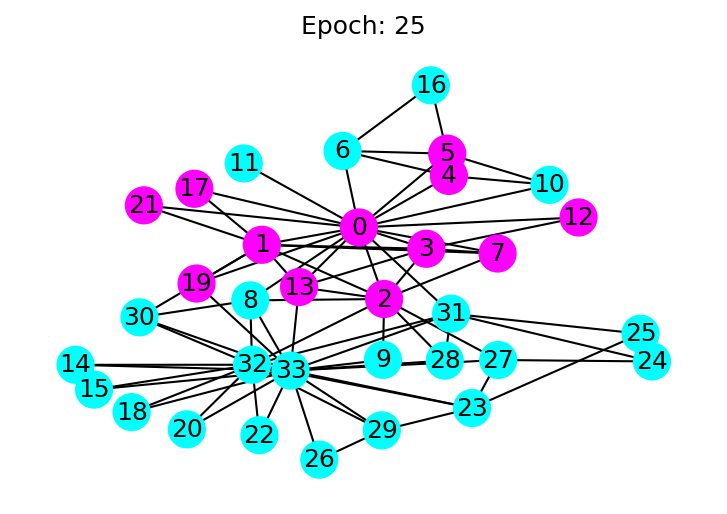

In [37]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):#循环画节点
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)#根据类型设置颜色
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(25)  # draw the prediction of the first epoch
plt.show()
plt.close()
